## Введение

### **Сценарий:**
Сеть фаст-фуда планирует добавить новый пункт в свое меню. Однако они все еще не определились между тремя возможными маркетинговыми кампаниями для продвижения нового продукта. Для определения, какая рекламная акция оказывает наибольшее влияние на продажи, новый товар представляется на рынках в нескольких случайно выбранных местах. В каждом месте используется разная рекламная акция, и еженедельные продажи нового продукта записываются в течение первых четырех недель.

### **Цель:**
Оценить результаты A/B-тестирования и определить, какая маркетинговая стратегия работает лучше всего.

## Данные и переменные

### **Столбцы:**
* **MarketID**: уникальный идентификатор рынка
* **MarketSize**: размер рыночной зоны по объему продаж
* **LocationID**: уникальный идентификатор местоположения магазина
* **AgeOfStore**: возраст магазина в годах
* **Promotion**: одна из трех протестированных акций
* **week**: одна из четырех недель, когда проводились акции
* **SalesInThousands**: сумма продаж для определенного LocationID, Promotion и week

In [1]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import drive
    drive.mount('/drive')

Mounted at /drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
import scipy.stats as stats

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multicomp import MultiComparison

import warnings
warnings.filterwarnings("ignore")

In [3]:
LINK = 'WA_Marketing-Campaign.csv'
if IS_COLAB:
    LINK = '/drive/MyDrive/Analytics/Fast Food Marketing/WA_Marketing-Campaign.csv'

data = pd.read_csv(LINK)
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## Анализ данных

In [4]:
data.shape

(548, 7)

In [5]:
data.dtypes

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

In [6]:
data.isnull().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [7]:
data.describe([0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
5%,1.000000,7.350000,1.000000,1.000000,1.000000,30.621500
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
95%,10.000000,913.650000,23.000000,3.000000,4.000000,88.458000
99%,10.000000,919.000000,27.000000,3.000000,4.000000,94.673800


Посморим на распределение по целевой переменной и на наличие выбросов.

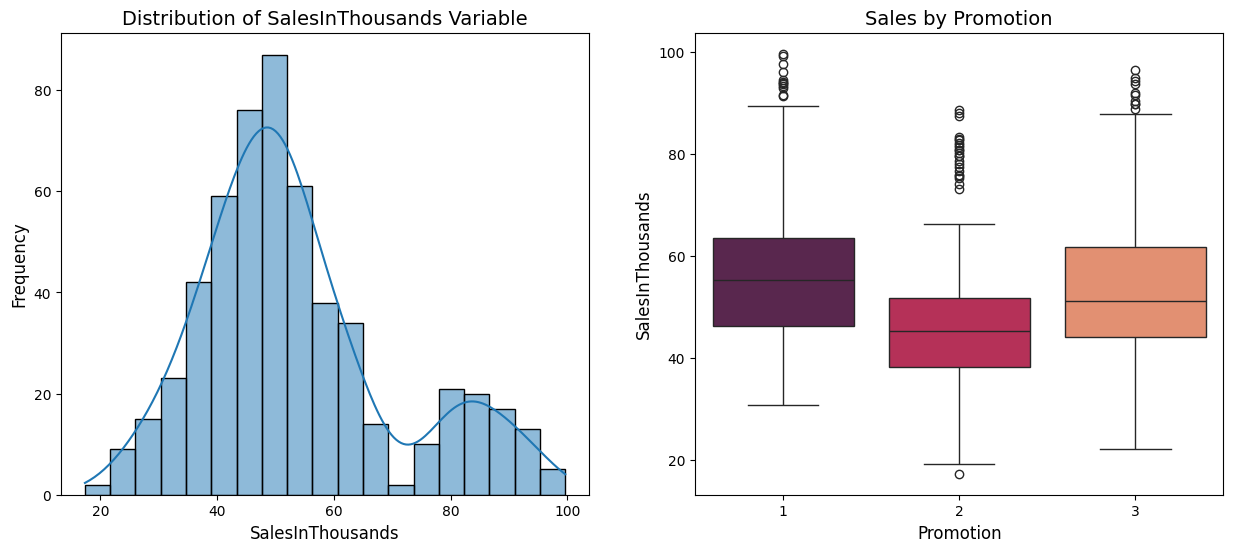

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.histplot(data['SalesInThousands'], kde=True, ax=ax1)
ax1.set_title("Distribution of SalesInThousands Variable", size=14)
ax1.set_xlabel("SalesInThousands", size=12)
ax1.set_ylabel("Frequency", size=12)

sns.boxplot(x='Promotion', y='SalesInThousands', data=data, ax=ax2, palette='rocket')
ax2.set_xlabel("Promotion",size=12)
ax2.set_ylabel("SalesInThousands",size=12)
ax2.set_title("Sales by Promotion",size=14)
plt.show()

Видно, что распределение похоже на бимодальное, и что сильных выбросов нет.

In [9]:
# SalesInThousands = SIT

data_group = data.groupby('Promotion', as_index=False) \
    .agg({'SalesInThousands': ['mean', 'sum', 'count', 'median']}) \
    .rename(columns={
        'mean': 'SIT_mean',
        'sum': 'SIT_sum',
        'count': 'SIT_count',
        'median': 'SIT_median',
    })
data_group

Promotion SalesInThousands                               
                    SIT_mean   SIT_sum SIT_count SIT_median
0         1        58.099012   9993.03       172     55.385
1         2        47.329415   8897.93       188     45.385
2         3        55.364468  10408.52       188     51.165

Визуальзируем эти данные.

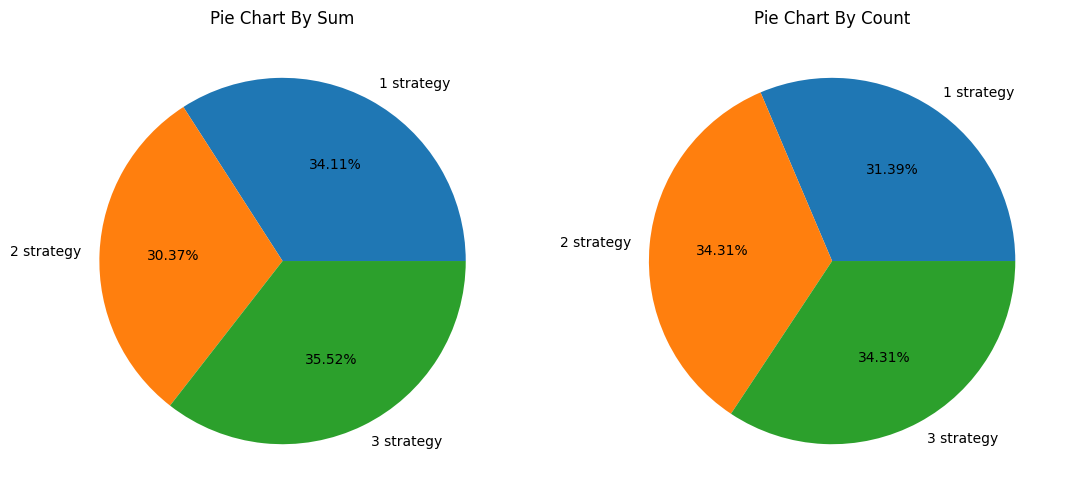

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))

labels_pie = ['1 strategy', '2 strategy', '3 strategy']

ax1.pie(x=data_group.SalesInThousands.SIT_sum, labels=labels_pie, autopct='%.2f%%')
ax1.set_title('Pie Chart By Sum', size=12)

ax2.pie(x=data_group.SalesInThousands.SIT_count, labels=labels_pie, autopct='%.2f%%')
ax2.set_title('Pie Chart By Count', size=12)

plt.show()

Видно, что выборки по сумме и по количеству продаж разделены имеют практически одинаково. Посмотрим теперь на разделение по размеру рынка.

In [11]:
data_market = data.groupby(['Promotion', 'MarketSize'], as_index=False) \
    .agg({'SalesInThousands': ['mean', 'sum', 'count', 'median']})

data_market.columns = data_market.columns.droplevel()
data_market.columns = ['Promotion', 'MarketSize', 'SIT_mean', 'SIT_sum', 'SIT_count', 'SIT_median']
data_market

,Promotion,MarketSize,SIT_mean,SIT_sum,SIT_count,SIT_median
0,1,Large,75.235893,4213.21,56,72.835
1,1,Medium,47.672604,4576.57,96,47.425
2,1,Small,60.162500,1203.25,20,61.145
3,2,Large,60.322031,3860.61,64,53.010
4,2,Medium,39.114352,4224.35,108,39.765
5,2,Small,50.810625,812.97,16,51.600
6,3,Large,77.203958,3705.79,48,82.345
7,3,Medium,45.468879,5274.39,116,46.295
8,3,Small,59.514167,1428.34,24,59.745


Визуализируем эти данные.

In [12]:
def format_divide1000(x, pos):
    return f'{x/1000:,.0f}'

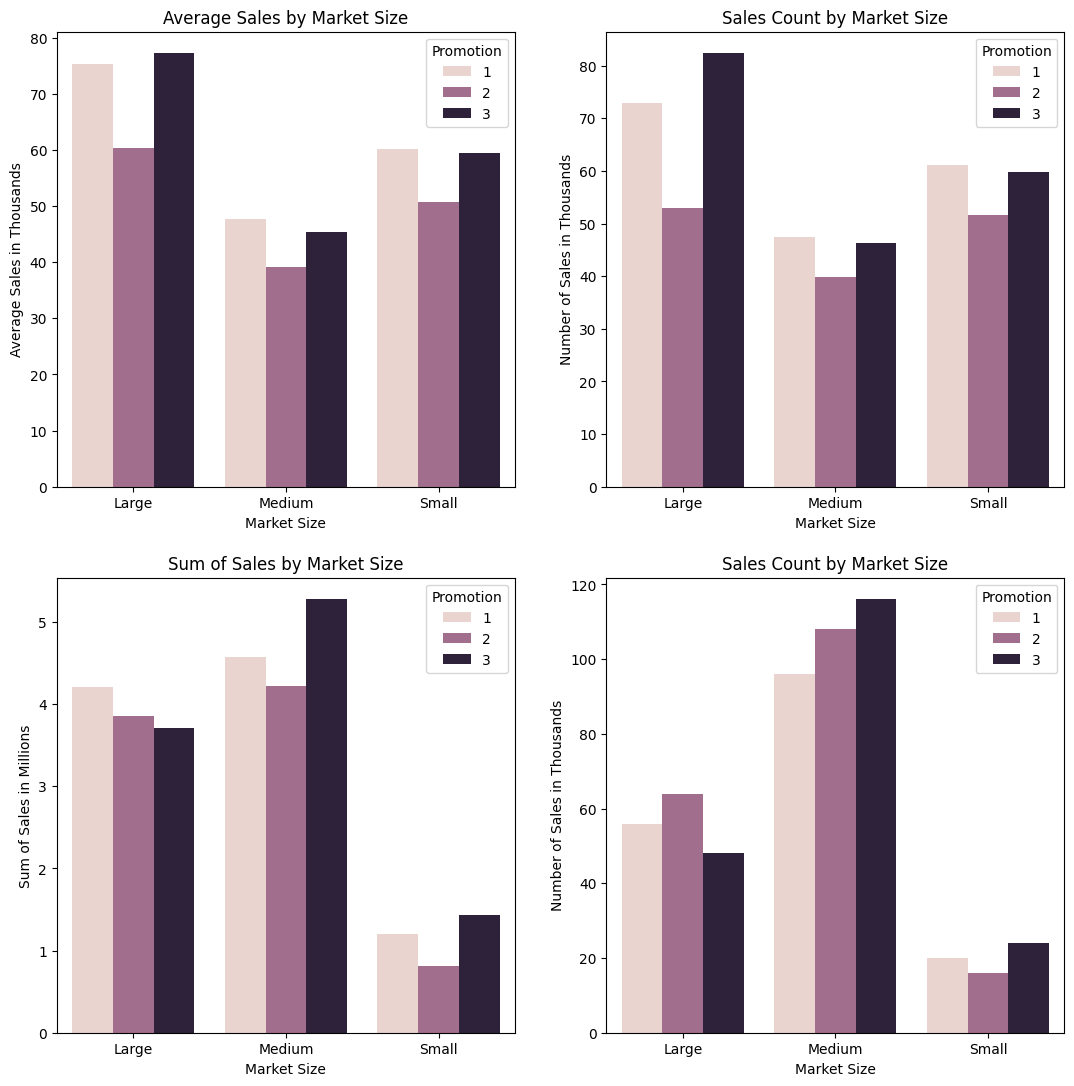

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13))

sns.barplot(x='MarketSize', y='SIT_mean', hue='Promotion', data=data_market, ax=axes[0][0])
axes[0][0].set_title('Average Sales by Market Size')
axes[0][0].set_xlabel('Market Size')
axes[0][0].set_ylabel('Average Sales in Thousands')

sns.barplot(x='MarketSize', y='SIT_median', hue='Promotion', data=data_market, ax=axes[0][1])
axes[0][1].set_title('Sales Count by Market Size')
axes[0][1].set_xlabel('Market Size')
axes[0][1].set_ylabel('Number of Sales in Thousands')

sns.barplot(x='MarketSize', y='SIT_sum', hue='Promotion', data=data_market, ax=axes[1][0])
axes[1][0].set_title('Sum of Sales by Market Size')
axes[1][0].set_xlabel('Market Size')
axes[1][0].set_ylabel('Sum of Sales in Millions')
axes[1][0].yaxis.set_major_formatter(tkr.FuncFormatter(format_divide1000))

sns.barplot(x='MarketSize', y='SIT_count', hue='Promotion', data=data_market, ax=axes[1][1])
axes[1][1].set_title('Sales Count by Market Size')
axes[1][1].set_xlabel('Market Size')
axes[1][1].set_ylabel('Number of Sales in Thousands')

plt.show()

Теперь посмотрим на распределение данных по неделям и возрасту.

In [14]:
data['AgeBins'] = pd.cut(data['AgeOfStore'], bins = [0, 5, 10, 15, 20, 25, 30],
                         labels=["0-5", "6-10", "11-15", "16-20", "21-25", "26-30"])

data_age = data.groupby(['Promotion', 'AgeBins'], as_index=False)['SalesInThousands'].mean()
data_age.dropna(inplace=True)
data_age

,Promotion,AgeBins,SalesInThousands
0,1,0-5,62.887639
1,1,6-10,55.732500
2,1,11-15,48.007188
3,1,16-20,63.560833
4,1,21-25,63.045000
5,1,26-30,52.392500
6,2,0-5,45.772875
7,2,6-10,47.246563
8,2,11-15,49.887917
9,2,16-20,39.421250


In [15]:
data_week = data.groupby(['Promotion', 'week'], as_index=False)['SalesInThousands'].mean()
data_week.dropna(inplace=True)
data_week

,Promotion,week,SalesInThousands
0,1,1,58.244419
1,1,2,56.929535
2,1,3,58.774884
3,1,4,58.447209
4,2,1,47.730213
5,2,2,47.582553
6,2,3,47.722128
7,2,4,46.282766
8,3,1,55.776170
9,3,2,55.949149


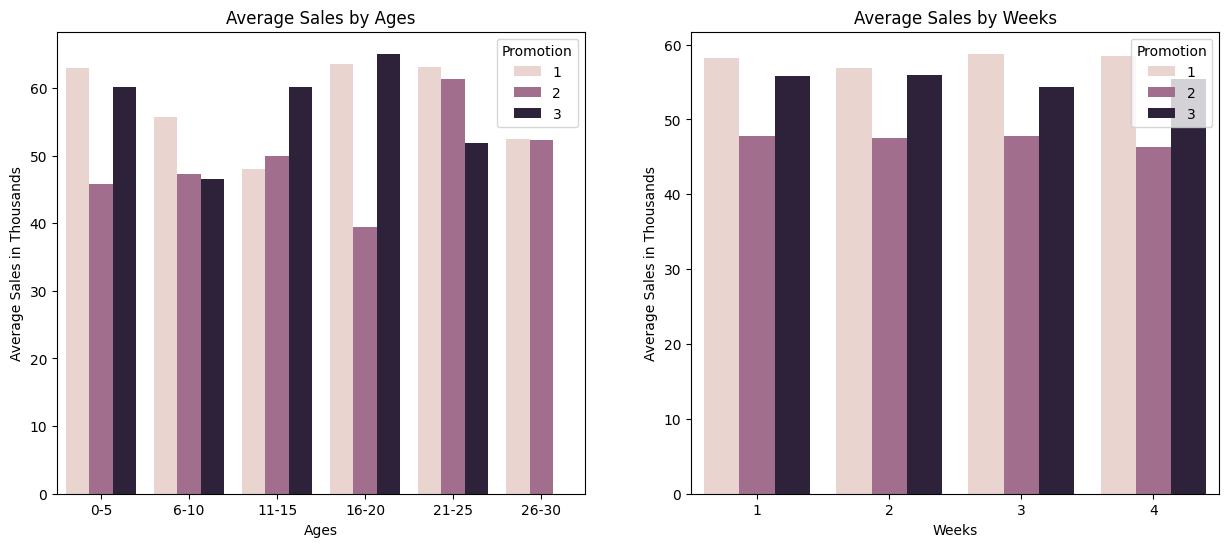

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.barplot(x='AgeBins', y='SalesInThousands', hue='Promotion', data=data_age, ax=ax1)
ax1.set_title('Average Sales by Ages')
ax1.set_xlabel('Ages')
ax1.set_ylabel('Average Sales in Thousands')

sns.barplot(x='week', y='SalesInThousands', hue='Promotion', data=data_week, ax=ax2)
ax2.set_title('Average Sales by Weeks')
ax2.set_xlabel('Weeks')
ax2.set_ylabel('Average Sales in Thousands')

plt.show()

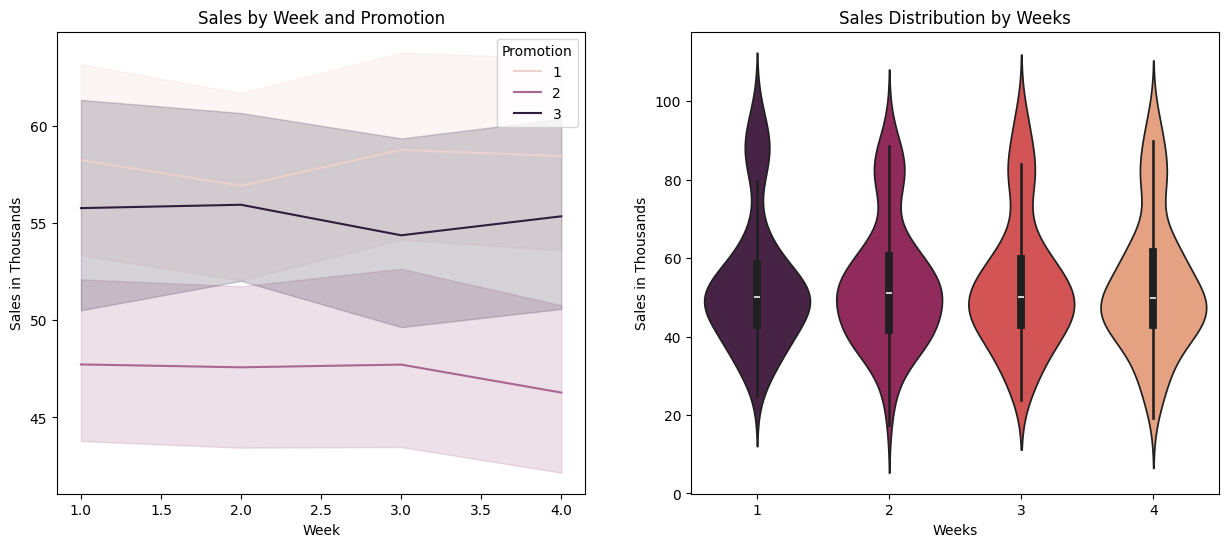

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.lineplot(x='week', y='SalesInThousands', hue='Promotion', data=data, ax=ax1)
ax1.set_title('Sales by Week and Promotion')
ax1.set_xlabel('Week')
ax1.set_ylabel('Sales in Thousands')

sns.violinplot(x='week', y='SalesInThousands', data=data, ax=ax2, palette='rocket')
ax2.set_title('Sales Distribution by Weeks')
ax2.set_xlabel('Weeks')
ax2.set_ylabel('Sales in Thousands')

plt.show()

## A/B-тестирование и проверка гипотез

In [18]:
promotion_1 = data[data['Promotion'] == 1]['SalesInThousands']
promotion_2 = data[data['Promotion'] == 2]['SalesInThousands']
promotion_3 = data[data['Promotion'] == 3]['SalesInThousands']

Проверим распределение данных на нормальность.

* Нулевая гипотеза: Данные распределны нормально

* Альтернативная гипотеза: Данные распределны  ненормально

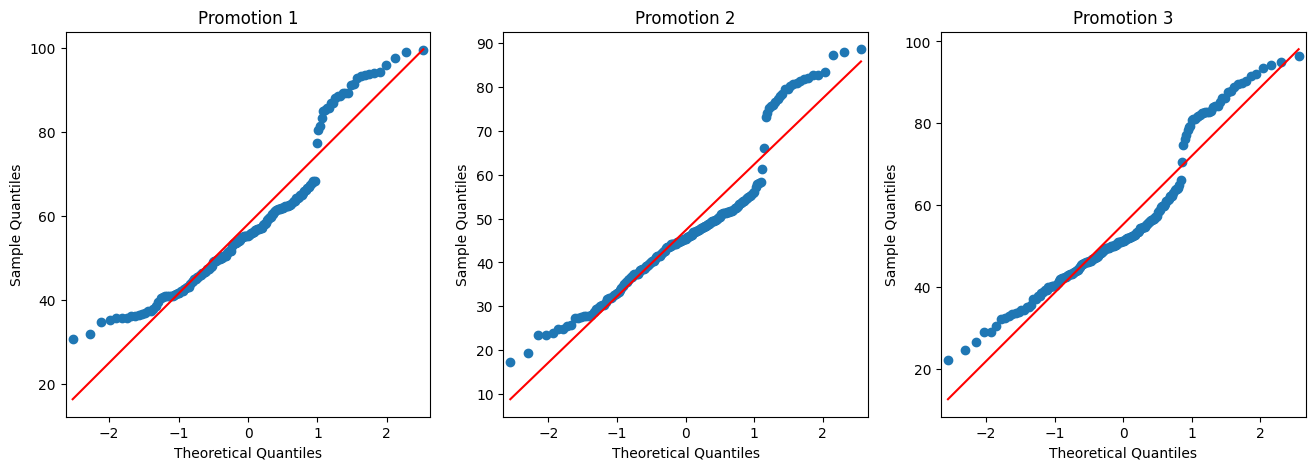

In [19]:
fig , axes = plt.subplots(1,3,figsize=(16,5))

qqplot(promotion_1, line="s", ax=axes[0])
axes[0].set_title("Promotion 1")

qqplot(promotion_2, line="s", ax=axes[1])
axes[1].set_title("Promotion 2")

qqplot(promotion_3, line="s", ax=axes[2])
axes[2].set_title("Promotion 3")

plt.show()

Видно, что данные не распределены нормально. Теперь проверим на гомогенность дисперсий.

* Нулевая гипотеза: Дисперсии гомогенны

* Альтернативная гипотеза: Дисперсии не гомогенны

In [20]:
stat_val, pvalue_stat = stats.levene(promotion_1, promotion_2, promotion_3)
print('Stat = %.4f, Pvalue = %.4f' % (stat_val, pvalue_stat))

Stat = 1.2697, Pvalue = 0.2818


Нельзя отклонить гипотезу о гомогенности диспресий.

Используем непараметрический критерий Краскела — Уоллиса (медианы):

* Нулевая гипотеза: Медианы равны

* Альтернативная гипотеза: Медианы не равны

In [21]:
stat_kruskal, pvalue_kruskal = stats.kruskal(promotion_1, promotion_2, promotion_3)
print('Stat = %.4f, Pvalue = %.4f' % (stat_kruskal, pvalue_kruskal))

Stat = 53.2948, Pvalue = 0.0000


Используем однофакторный ANOVA (средние):

* Нулевая гипотеза: Средние равны

* Альтернативная гипотеза: Средние не равны

In [22]:
f_stat, f_pvalue = stats.f_oneway(promotion_1, promotion_2, promotion_3)
print('Stat = %.4f, Pvalue = %.4f' % (f_stat, f_pvalue))

Stat = 21.9535, Pvalue = 0.0000


Для обоих критериев получаем одинаковый результат о наличии статистически значимиых результатов и отклонении нулевой гипотезы на уровне 0.05. Теперь посмортим, что именно даёт такой результат.

In [23]:
data_group

Promotion SalesInThousands                               
                    SIT_mean   SIT_sum SIT_count SIT_median
0         1        58.099012   9993.03       172     55.385
1         2        47.329415   8897.93       188     45.385
2         3        55.364468  10408.52       188     51.165

In [24]:
alpha = 0.05

comparison = MultiComparison(data["SalesInThousands"], data["Promotion"])
tukey = comparison.tukeyhsd(alpha)

print(comparison.tukeyhsd(alpha))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


Поскольку и медиана, и средняя для второй маркетинговой кампании меньше остальных медиан и средних соответственно, и учитывая попарное сравнение выше, получаем, что 2 кампания имеет хуже, чем 1 и 3. Гипотезу об отсутсвии статистически значимой разницы между 1 и 3 кампанией отклонить нельзя.

## Выводы

По результатам A/B-тестирования были получены статистически значимые результаты:

* 2 кампания на уровне 0.05 показала себя хуже, чем 1 и 3 кампании;

* Про статистически значимые различия 1 и 3 кампаний сказать ничего нельзя.